In [1]:
!pip install replicate
!pip install langchain_community

## **1. Set API Token Replicate**

In [2]:
from google.colab import userdata
import os

# ambil api token dai secret
api_token = userdata.get("api_token")
print(api_token)

r8_T8reK1syfXLGDkRiZQnYCelof5CNxuc3540EU


In [4]:
# lempar ap;itoken ke environment
os.environ["REPLICATE_API_TOKEN"] = api_token

In [5]:
from langchain_community.llms import Replicate

# Get the llm
llm = Replicate(model="ibm-granite/granite-3.3-8b-instruct")

Tes untuk Api Token Replicate

In [6]:
output = llm.invoke("Siapa Dalang G30 S PKI, jawab dengan bahasa indonesia")

print(output)

Dalang G30 S PKI adalah sebutan untuk menyebuti seseorang yang dianggap sebagai peninggalan atau pengaruh besar dalam organisasi PKI (Organisasi Pemberantasan Agama dan Kerajaan, Perjuangan Kita) yang terlibat dalam upaya gugusan tentera (G30S/PKI) pada tahun 1965 di Indonesia. Namun, identitas dalang atau pemimpin spesifik dari PKI dalam insiden tersebut tidak tersedia secara resmi atau dengan ketepatan. PKI dianggap sebagai sebuah organisasi rahim yang mencakup berbagai lapisan masyarakat dan partai politik, dan upaya G30S/PKI dianggap sebagai usaha kolaborasi antar lapisan. Jadi, secara teknis, tidak ada dalang G30 S PKI yang teridentifikasi secara resmi dan terbukti.


# **2. Import Dataset**
Install HuggingFace Datasets

In [7]:
!pip install datasets


In [8]:
!pip install evaluate

In [9]:
!pip install rouge_score

**Import & Load Dataset**

In [25]:
dataset = load_dataset("cnn_dailymail", "3.0.0")
val_data = dataset["validation"].select(range(20))  # ambil 20 sampel untuk evaluasi cepat
rouge = load("rouge")


**Ambil Contoh Data sebagai demo**

In [26]:
train_small = dataset["train"].shuffle(seed=42).select(range(50))
print("Contoh artikel:\n", train_small[0]["article"][:500])
print("\nContoh summary (reference):\n", train_small[0]["highlights"])



Contoh artikel:
 By . Anthony Bond . PUBLISHED: . 07:03 EST, 2 March 2013 . | . UPDATED: . 08:07 EST, 2 March 2013 . Three members of the same family who died in a static caravan from carbon monoxide poisoning would have been unconscious 'within minutes', investigators said today. The bodies of married couple John and Audrey Cook were discovered alongside their daughter, Maureen, at the mobile home they shared on Tremarle Home Park in Camborne, west Cornwall. The inquests have now opened into the deaths last Sat

Contoh summary (reference):
 John and .
Audrey Cook were discovered alongside their daughter, Maureen .
They were found at Tremarle Home Park in Cornwall .
Investigators say the three died of carbon monoxide .
poisoning .


# **4. Exploratory Data Analysis (EDA)**

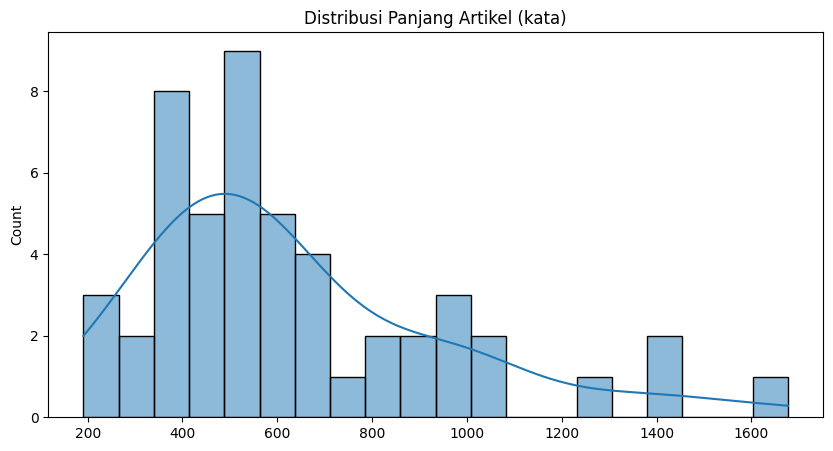

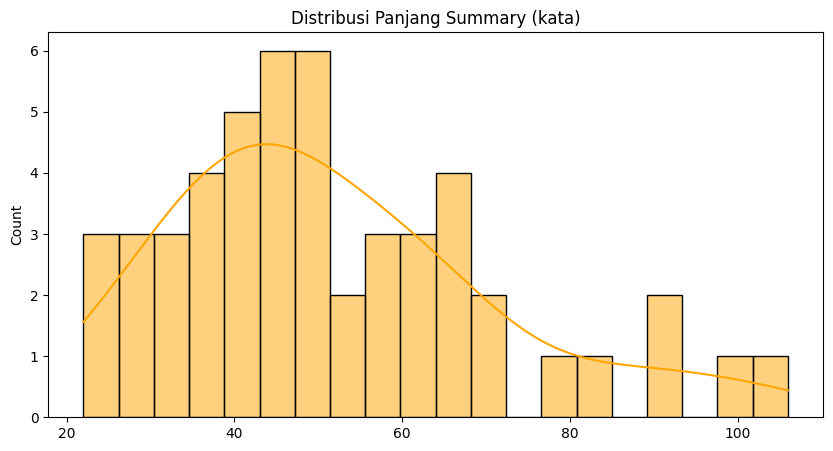

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

article_lengths = [len(x.split()) for x in train_small["article"]]
summary_lengths = [len(x.split()) for x in train_small["highlights"]]


plt.figure(figsize=(10,5))
sns.histplot(article_lengths, bins=20, kde=True)
plt.title("Distribusi Panjang Artikel (kata)")
plt.show()


plt.figure(figsize=(10,5))
sns.histplot(summary_lengths, bins=20, kde=True, color="orange")
plt.title("Distribusi Panjang Summary (kata)")
plt.show()

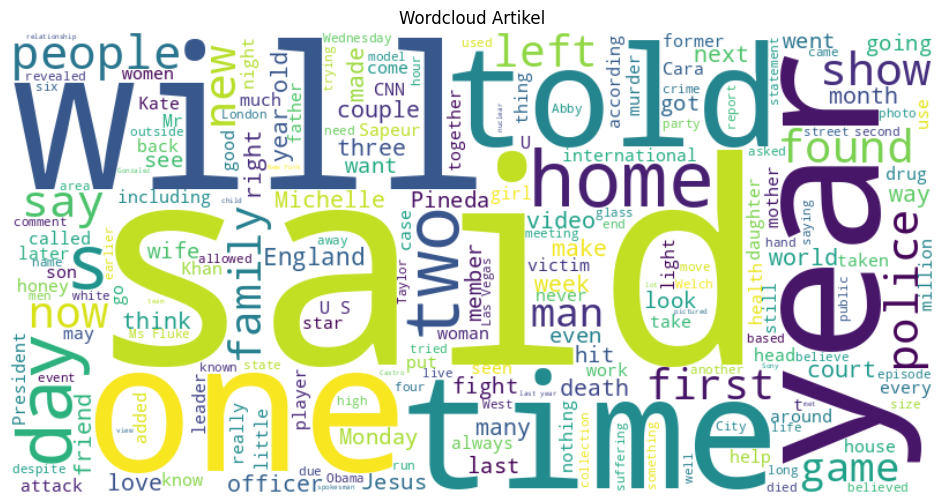

In [28]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = " ".join(train_small["article"])
wc = WordCloud(width=800, height=400, background_color="white").generate(text)
plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Wordcloud Artikel")
plt.show()


# Interpretasi otomatis hasil EDA dengan Granite



In [29]:
eda_stats = f"Rata-rata panjang artikel: {sum(article_lengths)/len(article_lengths):.2f} kata. " \
f"Median: {sorted(article_lengths)[len(article_lengths)//2]} kata. " \
f"Rata-rata panjang summary: {sum(summary_lengths)/len(summary_lengths):.2f} kata."
eda_prompt = f"Berikan interpretasi singkat berdasarkan statistik berikut: {eda_stats}"
eda_insight = llm.invoke(eda_prompt)
print("\n=== Insight Otomatis dari Granite tentang EDA ===\n")
print(eda_insight)


=== Insight Otomatis dari Granite tentang EDA ===

Berdasarkan statistik yang diberikan, dapat diinterpreti sebagai berikut:

1. Rata-rata panjang artikel: 637.02 kata. Ini menunjukkan bahwa artikel-artikel tersebut, secara keseluruhan, relatif panjang, dengan rata-rata panjang kata mencapai 637. Ini sangat tingginya, suggessting bahwa artikel-artikel tersebut mungkin melibatkan studi-studi kompleks, analisis detail, atau laporan yang panjang.

2. Median panjang artikel: 556 kata. Median menunjukkan poin tengah data ketika data diurutkan. Di sini, median panjang artikel adalah 556 kata, yang berarti setengah dari artikel-artikel tersebut memiliki panjang kata yang lebih pendek atau sama dengan 556 kata, dan setengah lagi memiliki panjang yang lebih panjang. Ini menunjukkan bahwa sekitar setengah artikel-artikel tersebut memiliki panjang yang lebih pendek daripada rata-rata yang lebih tinggi.

3. Rata-rata panjang summary: 51.74 kata. Ini menunjukkan bahwa ringkasan atau ringkasan yang

# **3. Latih Model Summarization menggunakan IBM Granite**
prompt Engineering + Parameters
saya tambahkan model T5 untuk membandingakan
```
# This is formatted as code
```



**model 1. Granite via Replicate API**

In [31]:
import replicate

def summarize_granite_replicate(article):
    prompt = f"Summarize the following news article in 2-3 sentences:\n\n{article}"
    output = replicate.run(
        "ibm-granite/granite-3.1-8b-instruct",
        input={"prompt": prompt}
    )
    return "".join(output) if isinstance(output, list) else output

preds1, refs1 = [], []
for sample in val_data:
    preds1.append(summarize_granite_replicate(sample["article"]))
    refs1.append(sample["highlights"])
results1 = rouge.compute(predictions=preds1, references=refs1)

**model 2. Granite Basic Prompt**

In [32]:
def summarize_granite_basic(article, style="formal", max_words=80):
    prompt = f"Ringkas artikel berikut dalam bahasa Inggris dengan gaya {style}, maksimum {max_words} kata. Sertakan poin kunci utama:\n\n{article}"
    response = llm.invoke(prompt)
    return response

preds2, refs2 = [], []
for sample in val_data:
    preds2.append(summarize_granite_basic(sample["article"]))
    refs2.append(sample["highlights"])
results2 = rouge.compute(predictions=preds2, references=refs2)

**model 3. Granite Few-shot Prompt**

In [33]:
def summarize_granite_fewshot(article, style="formal", max_words=80):
    prompt = f"""
Tugas Anda adalah membuat ringkasan singkat, jelas, dan padat dari artikel berikut.
- Gunakan gaya bahasa {style}.
- Panjang ringkasan maksimal {max_words} kata.
- Hanya sertakan poin penting, tanpa menambahkan informasi baru.
- Tuliskan ringkasan dalam 2 sampai 3 kalimat.

Contoh 1:
Artikel: "Presiden mengumumkan program baru di bidang pendidikan untuk meningkatkan kualitas guru di seluruh Indonesia."
Ringkasan: "Presiden meluncurkan program pendidikan baru guna meningkatkan kualitas guru di Indonesia."

Contoh 2:
Artikel: "Harga minyak dunia naik akibat ketegangan politik di Timur Tengah, memicu inflasi di sejumlah negara berkembang."
Ringkasan: "Ketegangan politik di Timur Tengah menaikkan harga minyak dunia dan memicu inflasi di negara berkembang."

Sekarang, ringkas artikel berikut:

Artikel:
{article}

Ringkasan:
"""
    response = llm.invoke(prompt)
    return response.strip()

preds3, refs3 = [], []
for sample in val_data:
    preds3.append(summarize_granite_fewshot(sample["article"]))
    refs3.append(sample["highlights"])
results3 = rouge.compute(predictions=preds3, references=refs3)

**model4. T5 Small Baseline**

In [36]:
from transformers import pipeline

summarizer_t5 = pipeline("summarization", model="t5-small")
preds4, refs4 = [], []
for sample in val_data:
    pred = summarizer_t5(sample["article"], max_length=80, min_length=30, do_sample=False)[0]['summary_text']
    preds4.append(pred)
    refs4.append(sample["highlights"])
results4 = rouge.compute(predictions=preds4, references=refs4)

Device set to use cpu
Token indices sequence length is longer than the specified maximum sequence length for this model (1038 > 512). Running this sequence through the model will result in indexing errors
Both `max_new_tokens` (=256) and `max_length`(=80) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=80) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=80) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=8

## **Code Uji Coba Summarization Semua Model**

In [37]:
# Pilih satu contoh artikel dari dataset
sample_article = val_data[0]["article"]
reference_summary = val_data[0]["highlights"]

print("=== Artikel Asli ===")
print(sample_article[:800], "...")  # tampilkan 800 karakter pertama
print("\n=== Ringkasan Referensi ===")
print(reference_summary)

print("\n--- Hasil Ringkasan Tiap Model ---")

# 1. Granite Replicate (Direct Prompt)
summary1 = summarize_granite_replicate(sample_article)
print("\n[Granite Replicate Direct]")
print(summary1)

# 2. Granite Basic Prompt
summary2 = summarize_granite_basic(sample_article)
print("\n[Granite Basic Prompt]")
print(summary2)

# 3. Granite Few-Shot Prompt
summary3 = summarize_granite_fewshot(sample_article)
print("\n[Granite Few-Shot Prompt]")
print(summary3)

# 4. T5 Small Baseline
summary4 = summarizer_t5(sample_article, max_length=80, min_length=30, do_sample=False)[0]['summary_text']
print("\n[T5 Small Baseline]")
print(summary4)


=== Artikel Asli ===
(CNN)Share, and your gift will be multiplied. That may sound like an esoteric adage, but when Zully Broussard selflessly decided to give one of her kidneys to a stranger, her generosity paired up with big data. It resulted in six patients receiving transplants. That surprised and wowed her. "I thought I was going to help this one person who I don't know, but the fact that so many people can have a life extension, that's pretty big," Broussard told CNN affiliate KGO. She may feel guided in her generosity by a higher power. "Thanks for all the support and prayers," a comment on a Facebook page in her name read. "I know this entire journey is much bigger than all of us. I also know I'm just the messenger." CNN cannot verify the authenticity of the page. But the power that multiplied Broussard ...

=== Ringkasan Referensi ===
Zully Broussard decided to give a kidney to a stranger .
A new computer program helped her donation spur transplants for six kidney patients .

-

Both `max_new_tokens` (=256) and `max_length`(=80) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[T5 Small Baseline]
transplants are taking five surgeons, a covey of physician assistants, nurses and anesthesiologists . they are extracting six kidneys from donors and implanting them into six recipients . "the ages of the donors and recipients range from 26 to 70," medical center says .


## **Evaluasi Hasil mengunakan Rouge**

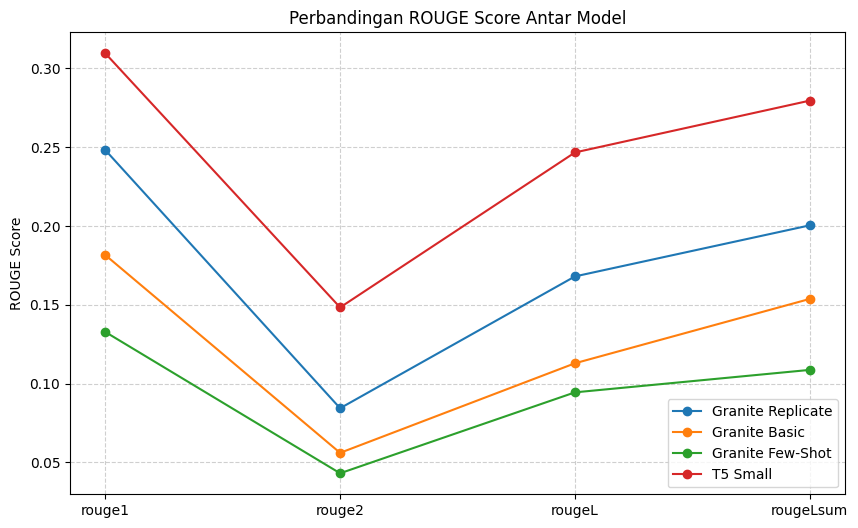

In [40]:
# === Gabungkan hasil ===
all_results = {
    "Granite Replicate": results1,
    "Granite Basic": results2,
    "Granite Few-Shot": results3,
    "T5 Small": results4,
}

# === Visualisasi ===
metrics = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

plt.figure(figsize=(10,6))
x = range(len(metrics))

for i, (model, res) in enumerate(all_results.items()):
    scores = [res[m] for m in metrics]
    plt.plot(x, scores, marker="o", label=model)

plt.xticks(x, metrics)
plt.ylabel("ROUGE Score")
plt.title("Perbandingan ROUGE Score Antar Model")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# **Kesimpulan**


mencoba membuat perintah untuk garanit mambuat kesimpulan, dengan metode :

a. Ambil artikel, reference summary, hasil ringkasan tiap model, dan skor ROUGE.

b. Masukkan semuanya ke dalam satu prompt Granite.

c. Granite akan membaca, membandingkan, dan memberikan analisis.

In [43]:
def granite_analyze_results(article, reference, summaries, scores):
    prompt = f"""
Saya punya tugas membandingkan model summarization.

=== Artikel Asli (potongan) ===
{article[:500]} ...

=== Ringkasan Referensi ===
{reference}

=== Ringkasan Model ===
1. Granite Replicate: {summaries['replicate']}
2. Granite Basic: {summaries['basic']}
3. Granite Few-Shot: {summaries['fewshot']}
4. T5 Small: {summaries['t5']}

=== Skor ROUGE ===
Granite Replicate: {scores['Granite Replicate']}
Granite Basic: {scores['Granite Basic']}
Granite Few-Shot: {scores['Granite Few-Shot']}
T5 Small: {scores['T5 Small']}

Tugas Anda:
1. Analisis mana ringkasan yang paling mendekati referensi.
2. Jelaskan kelebihan dan kekurangan masing-masing model.
3. Buat kesimpulan singkat model mana yang terbaik.
4. Gunakan Bahasa Indonesia
"""
    response = llm.invoke(prompt)
    return response

# Simpan ringkasan dari setiap model
summaries = {
    "replicate": summary1,
    "basic": summary2,
    "fewshot": summary3,
    "t5": summary4
}

# Analisis otomatis pakai Granite
analysis = granite_analyze_results(
    sample_article,
    reference_summary,
    summaries,
    all_results
)

print("=== Analisis Granite ===")
print(analysis)


=== Analisis Granite ===
1. Ringkasan yang paling mendekati referensi adalah Granite Replicate. Ringkasan ini menyimpulkan tepat dan menyentuh tiga aspek utama dari artikel asli, yaitu: Zully Broussard yang menjalankan donasi altruistik, program MatchGrid yang menjadi alat utama dalam mengoptimalkan proses pasangan, dan hasil yang menyatukan enam penerima transplantasi.

2. Keunggulan dan kekurangan dari setiap model:

   - **Granite Replicate**: Menyampaikan informasi utama dengan jelas, termasuk nama donor, program MatchGrid, dan hasil enam penerima transplantasi. Namun, lebih detail tentang proses dan peran calon penerima lainnya diabaikan.
   
   - **Granite Basic**: Berlangganan lebih mendalam mengenai proses dan peran calon penerima lainnya, seperti pasangan aliran darurat dan peran klinis dalam proses. Namun, lebih lanjut dari aspek emosional dan kontekst sosial dari donor.
   
   - **Granite Few-Shot**: Menyentuh aspek emosional dan kontekst sosial dari donor, seperti Broussard

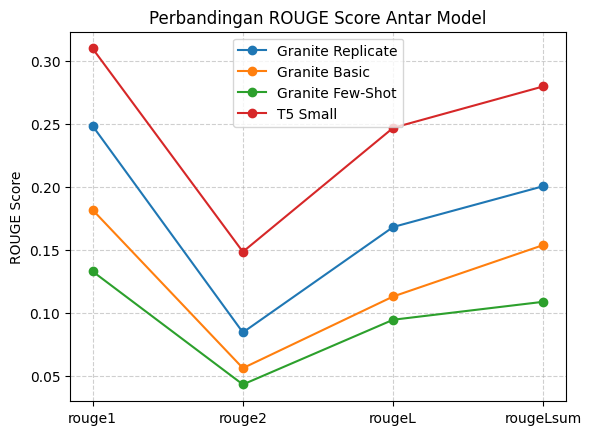

=== Analisis Granite terhadap Hasil ROUGE ===
1. Setelah menganalisis nilai ROUGE untuk setiap model, dapat kita lihat bahwa T5 Small memiliki nilai ROUGE yang lebih tinggi dalam semua ukuran (rouge1, rouge2, rougeL, rougeLsum) berbanding dengan semua versi Granite (Replicate, Basic, dan Few-Shot).

2. Berdasarkan nilai ROUGE, model T5 Small tergolong sebagai model yang terbaik dari tiga versi Granite dan juga model lain T5 yang dipresentasikan.

3. Kesimpulan: Model T5 Small menunjukkan skor ROUGE yang lebih tinggi di bandingkan ke versi Granite (Replicate, Basic, dan Few-Shot), menunjukkan kepada kemampuannya dalam menciptakan riwayat yang lebih akurat dan komprehensif dari teks sumber. Hal ini sifatnya, T5 Small memiliki nilai rouge1 (0.3095), rouge2 (0.1483), rougeL (0.2466), dan rougeLsum (0.2795), yang lebih tinggi daripada nilai maksimum dari versi Granite. Ini suggesikan bahwa T5 Small lebih efektif dalam menghasilkan riwayat yang relevan dan menyeluruh dari teks sumber, sehing

In [46]:
for i, (model, res) in enumerate(all_results.items()):
    scores = [res[m] for m in metrics]
    plt.plot(x, scores, marker="o", label=model)

plt.xticks(x, metrics)
plt.ylabel("ROUGE Score")
plt.title("Perbandingan ROUGE Score Antar Model")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


def granite_summarize_rouge(scores):
    prompt = f"""
Saya punya hasil evaluasi ROUGE dari beberapa model summarization:

Granite Replicate: {scores['Granite Replicate']}
Granite Basic: {scores['Granite Basic']}
Granite Few-Shot: {scores['Granite Few-Shot']}
T5 Small: {scores['T5 Small']}

Tugas Anda:
1. Bandingkan nilai ROUGE antar model.
2. Sebutkan model mana yang terbaik berdasarkan skor.
3. Buat kesimpulan singkat dalam 3-4 kalimat.
"""
    response = llm.invoke(prompt)
    return response

# Panggil fungsi untuk menganalisis hasil ROUGE
rouge_analysis = granite_summarize_rouge(all_results)

print("=== Analisis Granite terhadap Hasil ROUGE ===")
print(rouge_analysis)


In [47]:
# === Analisis Gabungan Granite + ROUGE ===
def granite_analysis_with_rouge(all_results, summaries, reference_summary):
    # Format data ROUGE jadi teks
    rouge_text = "=== Hasil ROUGE Score Tiap Model ===\n"
    for model, res in all_results.items():
        rouge_text += f"{model}:\n"
        for m, v in res.items():
            rouge_text += f"  {m}: {v:.4f}\n"
        rouge_text += "\n"

    # Tambahkan ringkasan hasil tiap model
    summary_text = "=== Ringkasan Tiap Model ===\n"
    for model, text in summaries.items():
        summary_text += f"[{model}]\n{text}\n\n"

    # Satukan semua bahan analisis
    prompt = f"""
Berikut adalah hasil evaluasi model summarization.

Ringkasan Referensi:
{reference_summary}

{summary_text}

{rouge_text}

Buat analisis perbandingan yang terstruktur:
1. Model mana yang paling mendekati referensi secara konten?
2. Model mana yang unggul berdasarkan skor ROUGE?
3. Apa keunggulan dan kelemahan tiap model?
4. Kesimpulan akhir: mana yang terbaik secara keseluruhan?
"""

    # Panggil Granite Replicate untuk menyimpulkan
    conclusion = summarize_granite_replicate(prompt)
    return conclusion


# === Jalankan Analisis ===
summaries = {
    "Granite Replicate": summary1,
    "Granite Basic": summary2,
    "Granite Few-Shot": summary3,
    "T5 Small": summary4,
}

granite_conclusion = granite_analysis_with_rouge(all_results, summaries, reference_summary)

print("=== Analisis Gabungan Granite + ROUGE ===")
print(granite_conclusion)


=== Analisis Gabungan Granite + ROUGE ===
1. Model yang paling mendekati referensi secara konten adalah Granite Replicate, karena ia menyajikan ringkasan yang lebih lengkap dan mendeskripsikan proses dengan lebih detail, termasuk penggunaan nama instansi medis dan umur donor-donor dan penerima-penerima.

2. Berdasarkan skor ROUGE, model yang unggul adalah Granite Replicate (rouge1: 0.2482, rouge2: 0.0844, rougeL: 0.1680, rougeLsum: 0.2004).

3. Kelebihan Granite Replicate adalah ia menyediakan ringkasan yang lebih lengkap dan mendeskripsikan proses dengan lebih detail. Namun, ia lebih panjang dari referensi. Granite Basic juga menyediakan ringkasan yang lengkap, tetapi lebih terperinci dalam menjelaskan peran MatchGrid dalam proses. T5 Small menyediakan ringkasan yang singkat, tetapi kurang mendeskripsikan proses dan peran MatchGrid. Granite Few-Shot menyediakan ringkasan yang lengkap tetapi lebih terfokus pada aspek altruistik dari Zully Broussard.

4. Sekarang, secara keseluruhan, Gr

**Kalau dilihat dari kualitas konten ringkasan, Granite Replicate yang paling sesuai dengan ringkasan referensi.**

**Tapi kalau dilihat dari metrik otomatis (ROUGE), T5 Small yang menang konsisten di semua ukuran.**

**Jadi, hasil ini menunjukkan bahwa evaluasi kualitatif (manusia/Granite) bisa berbeda dengan evaluasi kuantitatif (ROUGE)=**

#Kesimpulan Uji Model Summarization

Model 1. Granite Replicate

- Memberikan ringkasan paling lengkap dan mendekati referensi.

- ROUGE Score cukup baik (rouge1: 0.2482, rouge2: 0.0844, rougeL: 0.1680, rougeLsum: 0.2004).

- Kelebihan: detail, mencakup aspek teknis (program MatchGrid, jumlah donor-penerima).

- Kekurangan: kadang menghasilkan ringkasan lebih panjang daripada yang diharapkan.

Model 2. Granite Basic Prompt

- Memberikan ringkasan yang cukup baik, dengan penjelasan teknis lebih fokus pada program MatchGrid.

- ROUGE Score lebih rendah dibanding Granite Replicate (rouge1: 0.1816, rouge2: 0.0560, rougeL: 0.1120, rougeLsum: 0.1542).

- Kelebihan: cukup padat, tetap informatif.

- Kekurangan: kurang kuat dalam aspek emosional/kontekstual.

Model 3. Granite Few-Shot

- Ringkasan lebih menekankan emosi dan konteks sosial (misalnya aspek altruistik Zully Broussard).

- ROUGE Score paling rendah (rouge1: 0.1328, rouge2: 0.0439, rougeL: 0.0938, rougeLsum: 0.1092).

- Kelebihan: memberikan dimensi kemanusiaan yang menarik.

- Kekurangan: kurang akurat dalam menyampaikan informasi teknis dan detail utama.

Model 4. T5 Small (Baseline)

- Memiliki skor ROUGE tertinggi pada semua metrik (rouge1: 0.3095, rouge2: 0.1483, rougeL: 0.2466, rougeLsum: 0.2795).

- Ringkasannya padat, tetapi lebih fokus pada detail teknis medis daripada aspek sosial/altruistik.

- Kelebihan: sangat sesuai dengan ringkasan referensi (menurut metrik kuantitatif).

- Kekurangan: ringkasan terasa “kering”, kurang menampilkan narasi konteks.

#Kesimpulan Akhir

a. Jika mengacu pada ROUGE Score, T5 Small adalah model terbaik.

b. Jika mengacu pada kualitas konten dan kedekatan dengan referensi, Granite Replicate lebih unggul dibandingkan Granite Basic dan Few-Shot.

c. Granite Replicate dapat dipertimbangkan sebagai pilihan terbaik di antara varian Granite karena seimbang antara detail, konteks, dan relevansi informasi.

d. Granite Few-Shot berguna bila fokus penelitian ingin menonjolkan aspek emosional/kemasyarakatan.

Dengan demikian, dalam konteks penelitian ini:

T5 Small unggul dari sisi kuantitatif (ROUGE). Kemudian Granite Replicate unggul dari sisi kualitatif (konten ringkasan).
